Term Project

Team: Weston Scott, Rain Price

ECE 523 | Engineering Applications of Machine Learning and Data Analytics

Professor Abhijit Mahalanobis

# Vehicle and People Detection with the FLIR Thermal Dataset

![alt text](problemStatement.png)

## TODO

- Get simple training model working
- Get resulting images and predictions showing
- Run all images through model and check error
- Rewrite Resnet layers to be our own homegrown solution?
- Survive this class ....

## Import Libraries

In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image, ImageFilter
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from torchvision.transforms.functional import pad

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
from torch.autograd import Variable
from torchvision import transforms as T
from torchvision.transforms import ToTensor, transforms
from copy import copy
import json
from tqdm import tqdm
from sklearn import metrics
import sys
import shutil

## Random Seed, Device Architecture, and Hyperparameters

In [2]:
%matplotlib inline
randomSeed = 2024
np.random.seed(randomSeed)
torch.manual_seed(randomSeed)

print(f'PyTorch Version: {torch.__version__}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch Device: {device}')

numWorkers = 2
if sys.platform == 'win32':
    numWorkers = 0
    
trackingLabels = ['person', 'car']
colors = ['m', 'b']
maxObjects = 20
numClasses = len(trackingLabels)
saveImagesVideos = True
videosDir = "videos"
samplesDir = f"{videosDir}/sample_imagery"
finalImagery = f"{videosDir}/images_truth_predict"

if not os.path.isdir(videosDir):
    os.mkdir(videosDir)
    
if not os.path.isdir(samplesDir):
    os.mkdir(samplesDir)

if os.path.isdir(finalImagery):
    shutil.rmtree(finalImagery)
    os.mkdir(finalImagery)

PyTorch Version: 2.2.0
PyTorch Device: cuda


## Classifier Params

In [3]:
batchSizeClass = 64
maxEpochsClassifier = 20
learnRateClass = 0.001
classifierModelPath = './classificationModel_20240505_2.pt'

saveClassifierModel = False
loadClassifierModel = True

## Detector Params

In [4]:
batchSizeDetect = 1
maxEpochsDetect = 20
learnRateDetect = 0.001
detectorModelPath = './DetectionModel_20240505_new.pt'

saveDetectionModel = False
loadDetectionModel = True

## Check to see if input images are the same size

In [5]:
path = 'data/images_thermal_train/data'

imgs = os.listdir(path)
sizes = []
for img in imgs:
    filename = os.path.join(path, img)
    image = Image.open(filename)
    sizes.append(image.size)
print(sizes[-1])
np.unique(sizes, return_counts=True)

(640, 512)


(array([512, 640]), array([10742, 10742]))

## Load Training/ Testing Data

In [6]:
trainPath = './data/images_thermal_train'
valPath = './data/images_thermal_val'
testPath = './data/video_thermal_test'
dataDir = 'data'
jsonFile = 'coco.json'
trimmedJsonFile = 'trimmed_coco.json'

jsonFiles = { 
              'train' : os.path.join(trainPath, jsonFile),
              'val' : os.path.join(valPath, jsonFile),
              'test' : os.path.join(testPath, jsonFile)
            }

jsonFilesTrimmed = { 
              'train' : os.path.join(trainPath, trimmedJsonFile),
              'val' : os.path.join(valPath, trimmedJsonFile),
              'test' : os.path.join(testPath, trimmedJsonFile)
            }

imagePaths = { 
              'train' : trainPath,
              'val' : valPath,
              'test' : testPath
            }

for key, val in jsonFiles.items():
    if os.path.isfile(val):
        print(f'coco.json Exists: {key}, {val}')
    
for key, val in imagePaths.items():
    if os.path.isdir(val):
        print(f'Data Directory Exists: {key}, {val}')
        
labelMap = {
            1:  'person',
            2:  'bike', #(renamed from "bicycle")
            3:  'car', #(this includes pick-up trucks and vans)
            4:  'motor', #(renamed from "motorcycle" for brevity)
            6:  'bus',
            7:  'train',
            8:  'truck', #(semi/freight truck, excluding pickup truck)
            10: 'light', #(renamed from "traffic light" for brevity)
            11: 'hydrant', #(renamed "fire hydrant" for brevity)
            12: 'sign', #(renamed from "street sign" for brevity)
            17: 'dog',
            18: 'deer',
            37: 'skateboard',
            73: 'stroller', #(four-wheeled carriage for a child, also called pram)
            75: 'scooter',
            79: 'other vehicle' #(less common vehicles like construction equipment and trailers)
          }

coco.json Exists: train, ./data/images_thermal_train/coco.json
coco.json Exists: val, ./data/images_thermal_val/coco.json
coco.json Exists: test, ./data/video_thermal_test/coco.json
Data Directory Exists: train, ./data/images_thermal_train
Data Directory Exists: val, ./data/images_thermal_val
Data Directory Exists: test, ./data/video_thermal_test


In [7]:
boxMaxWidth = 1
boxMaxHeight = 1
for key, val in jsonFiles.items():
    
    print(f"Generating trimmed coco.json files from: {val} for {key} data at: {jsonFilesTrimmed[key]} ...")
    with open(val, 'r') as f:
        data = json.load(f)

    images = []
    annotations = []
    imageIDs = []
    for annot in data['annotations']:
        if labelMap[annot['category_id']] in trackingLabels:
            annotations.append(annot)
            imageIDs.append(annot['image_id'])
            
            bbox = annot['bbox']
            if bbox[2] > boxMaxWidth:
                boxMaxWidth = bbox[2]
            if bbox[3] > boxMaxHeight:
                boxMaxHeight = bbox[3]
                
    imageIDs= np.unique(imageIDs)
    
    for i, image in enumerate(data['images']):
        if (image['id'] in imageIDs):
            images.append(image)
    
    trimmedData = { 'annotations': annotations,
                    'images': images,
                    'ids': dict(enumerate(trackingLabels))}
    
    with open(jsonFilesTrimmed[key], "w") as outfile: 
        json.dump(trimmedData, outfile, indent=4)

Generating trimmed coco.json files from: ./data/images_thermal_train/coco.json for train data at: ./data/images_thermal_train/trimmed_coco.json ...
Generating trimmed coco.json files from: ./data/images_thermal_val/coco.json for val data at: ./data/images_thermal_val/trimmed_coco.json ...
Generating trimmed coco.json files from: ./data/video_thermal_test/coco.json for test data at: ./data/video_thermal_test/trimmed_coco.json ...


In [8]:
boxMaxWidth =  int(boxMaxWidth * 640/image['width'])
boxMaxHeight = int(boxMaxHeight * 640/image['height'])

print(f'Maximum Object Box Width: {boxMaxWidth}')
print(f'Maximum Object Box Height: {boxMaxHeight}')
print(f'Maximum Number of Objects: {maxObjects}')
print(f'Number of Classes: {numClasses}')

del data, images, annotations, imageIDs, trimmedData, bbox

Maximum Object Box Width: 639
Maximum Object Box Height: 631
Maximum Number of Objects: 20
Number of Classes: 2


In [9]:
def sizeBoxImage(img, bbox):
    x, y, w, h = bbox
    x, y, w, h = int(x), int(y), int(w), int(h)
    img = img[y:y+h, x:x+w]
    if w <= 80 and h <= 80:
        img = cv2.resize(img, (80, 80))
    elif w <= 160 and h <= 160:
        img = cv2.resize(img, (160, 160))
        img = cv2.pyrDown(img)
    if w <= 320 and h <= 320:
        img = cv2.resize(img, (320, 320))
        img = cv2.pyrDown(img)
        img = cv2.pyrDown(img)
    else:
        img = cv2.resize(img, (640, 640))
        img = cv2.pyrDown(img)
        img = cv2.pyrDown(img)
        img = cv2.pyrDown(img) ## final image size is 80x80
    return img

class ThermalCocoDataset(Dataset):
    def __init__(self, jsonFile:str, imageDir:str, trackingLabels:list, labelMap:dict, maxWidth:int=2, maxHeight:int=2, singleObject:bool=False, transform=None, maxObjects:int=4):
        """
        Args:
            jsonFile (str): Path to the COCO-style JSON file containing annotations.
            imageDir (str): Directory containing the images.
            trackingLabels (list): List of tracking labels.
            labelMap (dict): Mapping of category IDs to labels.
            single_object (bool): Whether to treat each image as containing a single object.
            transform (callable, optional): Optional transform to be applied to the images.
            maxObjects (int): The max number of objects to process in an image.
        """

        self.jsonFile = jsonFile
        self.imageDir = imageDir
        self.transform = transform
        self.trackingLabels = trackingLabels
        self.labelMap = labelMap
        self.maxWidth = maxWidth
        self.maxHeight = maxHeight
        self.singleObject = singleObject
        self.maxObjects = maxObjects
        self._load_json()

    def _load_json(self):
        """Load JSON annotations."""

        with open(self.jsonFile, 'r') as f:
            data = json.load(f)

        self.annotations = data['annotations']
        self.images = data['images']

    def _adjust_bounding_box(self, bbox, width, height):
        """Adjust bounding box coordinates to match resized image."""

        # if self.singleObject:
        return [int(bbox[0] * (640 / width)),
                int(bbox[1] * (640 / height)),
                int(bbox[2] * (640 / width)),
                int(bbox[3] * (640 / height))]
        # else:
        #     return [int(bbox[0] * (320 / width)),
        #             int(bbox[1] * (320 / height)),
        #             int(bbox[2] * (320 / width)),
        #             int(bbox[3] * (320 / height))]

    def _get_single_object(self, idx):
        """Get image, label, bounding box, and number of objects for single object mode."""

        annotation = self.annotations[idx]
        image_id = annotation['image_id']
        for entry in self.images:
            if entry['id'] == image_id:
                image_file_name = entry['file_name']
                width = entry['width']
                height = entry['height']

        image_file = os.path.join(self.imageDir, f"{image_file_name}")
        img = cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img = cv2.resize(img, (640, 640))

        if self.labelMap[annotation['category_id']] in self.trackingLabels:
            # Assuming annotation format: [x, y, width, height]
            bbox = self._adjust_bounding_box(annotation['bbox'], width, height)
            tmpLabel = self.labelMap[annotation['category_id']]

        img = sizeBoxImage(img, bbox)
        label = torch.tensor(self.trackingLabels.index(tmpLabel))
        bbox = torch.tensor(bbox)

        if self.transform:
            img = self.transform(img)

        return img, label, bbox, torch.tensor(1)

    def _get_multi_objects(self, idx):
        """Get image, labels, bounding boxes, and number of objects for multi-object mode."""

        image = self.images[idx]
        image_file = os.path.join(self.imageDir, f"{image['file_name']}")
        img = cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img = cv2.resize(img, (640, 640))

        id = image['id']
        width = image['width']
        height = image['height']

        bboxes = []
        labels = []
        for entry in self.annotations:
            if entry['image_id'] == id:
                if (self.labelMap[entry['category_id']] in self.trackingLabels):
                    tmpLabel = self.labelMap[entry['category_id']]
                    bboxes.append(self._adjust_bounding_box(entry['bbox'], width, height))
                    labels.append(self.trackingLabels.index(tmpLabel))

        numObjects = torch.tensor(len(labels[:self.maxObjects]))
        # repeat_labels = (self.maxObjects + len(labels) - 1) // len(labels)
        # repeat_bboxes = (self.maxObjects + len(bboxes) - 1) // len(bboxes)

        # Repeat the elements of labels and bboxes
        # padded_labels = torch.tensor(labels * repeat_labels)[:self.maxObjects]
        # padded_bboxes = torch.tensor(bboxes * repeat_bboxes)[:self.maxObjects]
        padded_labels = torch.tensor(labels)
        padded_bboxes = torch.tensor(bboxes, dtype=torch.float32)

        if self.transform:
            # img = cv2.pyrDown(img)
            img = self.transform(img)

        return img, padded_labels, padded_bboxes, numObjects

    def __len__(self):
        """Return the number of images in the dataset."""

        if self.singleObject:
            return len(self.annotations)
        else:
            return len(self.images)

    def __getitem__(self, idx):
        """Get the image, labels, and bounding boxes for the given index."""

        if self.singleObject:
            return self._get_single_object(idx)
        else:
            return self._get_multi_objects(idx)

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[262.6299], std=[117.4840])  # Normalize image
])

In [10]:
trainDataClass = ThermalCocoDataset(jsonFilesTrimmed['train'], imagePaths['train'], trackingLabels, labelMap, 640, 640, True, transform=transform)
valDataClass = ThermalCocoDataset(jsonFilesTrimmed['val'], imagePaths['val'], trackingLabels, labelMap, 640, 640, True, transform=transform)
testDataClass = ThermalCocoDataset(jsonFilesTrimmed['test'], imagePaths['test'], trackingLabels, labelMap, 640, 640, True, transform=transform)

trainLoaderClass = DataLoader(trainDataClass, batch_size=batchSizeClass, shuffle=True, num_workers=numWorkers)
valLoaderClass = DataLoader(valDataClass, batch_size=batchSizeClass, shuffle=True, num_workers=numWorkers)
testLoaderClass = DataLoader(testDataClass, batch_size=batchSizeClass, shuffle=False, num_workers=numWorkers)

trainDataDetect = ThermalCocoDataset(jsonFilesTrimmed['train'], imagePaths['train'], trackingLabels, labelMap, transform=transform, maxObjects=maxObjects)
valDataDetect = ThermalCocoDataset(jsonFilesTrimmed['val'], imagePaths['val'], trackingLabels, labelMap, transform=transform, maxObjects=maxObjects)
testDataDetect = ThermalCocoDataset(jsonFilesTrimmed['test'], imagePaths['test'], trackingLabels, labelMap, transform=transform, maxObjects=maxObjects)

trainLoaderDetect = DataLoader(trainDataDetect, batch_size=batchSizeDetect, shuffle=True, num_workers=numWorkers)
valLoaderDetect = DataLoader(valDataDetect, batch_size=batchSizeDetect, shuffle=True, num_workers=numWorkers)
testLoaderDetect = DataLoader(testDataDetect, batch_size=1, shuffle=False, num_workers=numWorkers)

## Helpful Function Definitions

In [11]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2], bb[3], color=color,
                         fill=False, lw=1)

def show_corner_bb(im, bb, c=None, cLabel='', color='red', createFig=False):
    if createFig:
        plt.figure(figsize=(6,6))
        if not cLabel == '':
            plt.title(f'{cLabel} Class: {c}')
    plt.imshow(im.squeeze(), cmap=plt.cm.gray)
    plt.gca().add_patch(create_corner_rect(bb, color=color))
    
def plot_sample(image, labels, bboxes, num, showbb=True):
    
    plt.imshow(image.squeeze(), cmap="gray")  # Convert (C, H, W) tensor to (H, W, C) for plotting
    if showbb:
        plt.title(f'Number of Objects: {num}')
        try:
            for bbox, label in zip(bboxes, labels):
                try:
                    label = int(label)
                except:
                    label = int(label[0])
                x, y, w, h = bbox
                x, y, w, h = int(x), int(y), int(w), int(h)
                plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=1, edgecolor=colors[label], facecolor='none'))
                plt.text(x, y-5, f'{trackingLabels[label]}', color=colors[label])
        except:
            try:
                x, y, w, h = bboxes
            except:
                x, y, w, h = bboxes[0]
                label = label[0]
            label = int(label)
            x, y, w, h = int(x), int(y), int(w), int(h)
            plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=1, edgecolor=colors[labels], facecolor='none'))
            plt.text(x, y-5, f'{trackingLabels[labels]}', color=colors[labels])
        plt.axis('off')
    else:
        plt.title(f'Sample {trackingLabels[labels]}')

## Sample Imagery From Training Data

### Original Images (Training)

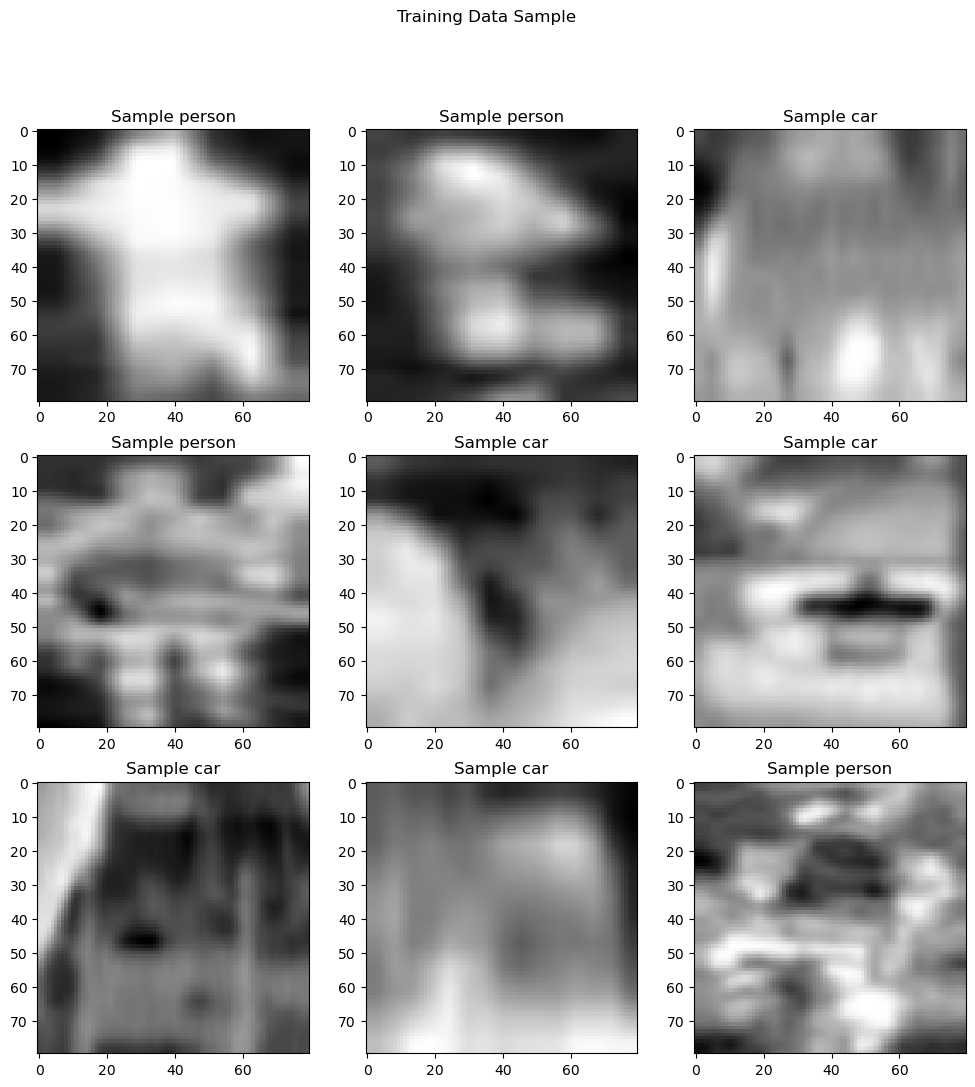

In [12]:
figure = plt.figure(figsize=(12, 12))
plt.suptitle('Training Data Sample')
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    idx = torch.randint(len(trainDataClass), size=(1,)).item()
    image, labels, bboxes, num = trainDataClass[idx]
    figure.add_subplot(rows, cols, i)
    plot_sample(image, labels.tolist(), bboxes.tolist(), num.item(), showbb=False)
if saveImagesVideos:
    plt.savefig(f'{samplesDir}/training_class')
plt.show()

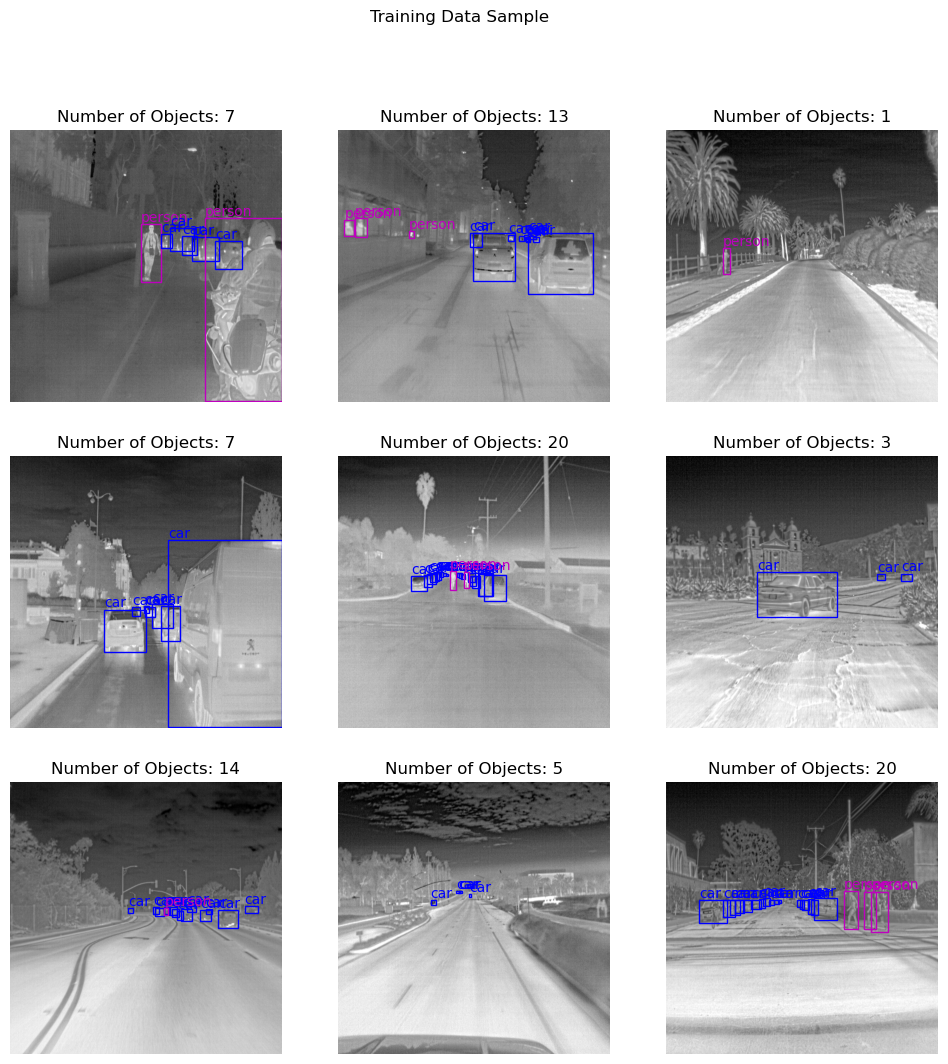

In [13]:
figure = plt.figure(figsize=(12, 12))
plt.suptitle('Training Data Sample')
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    idx = torch.randint(len(trainDataDetect), size=(1,)).item()
    image, labels, bboxes, num = trainDataDetect[idx]
    figure.add_subplot(rows, cols, i)
    labels = labels[:num]
    bboxes = bboxes[:num,:]
    plot_sample(image, labels.tolist(), bboxes.tolist(), num.item())
if saveImagesVideos:
    plt.savefig(f'{samplesDir}/training_detect')
plt.show()

### Original Images (Validation)

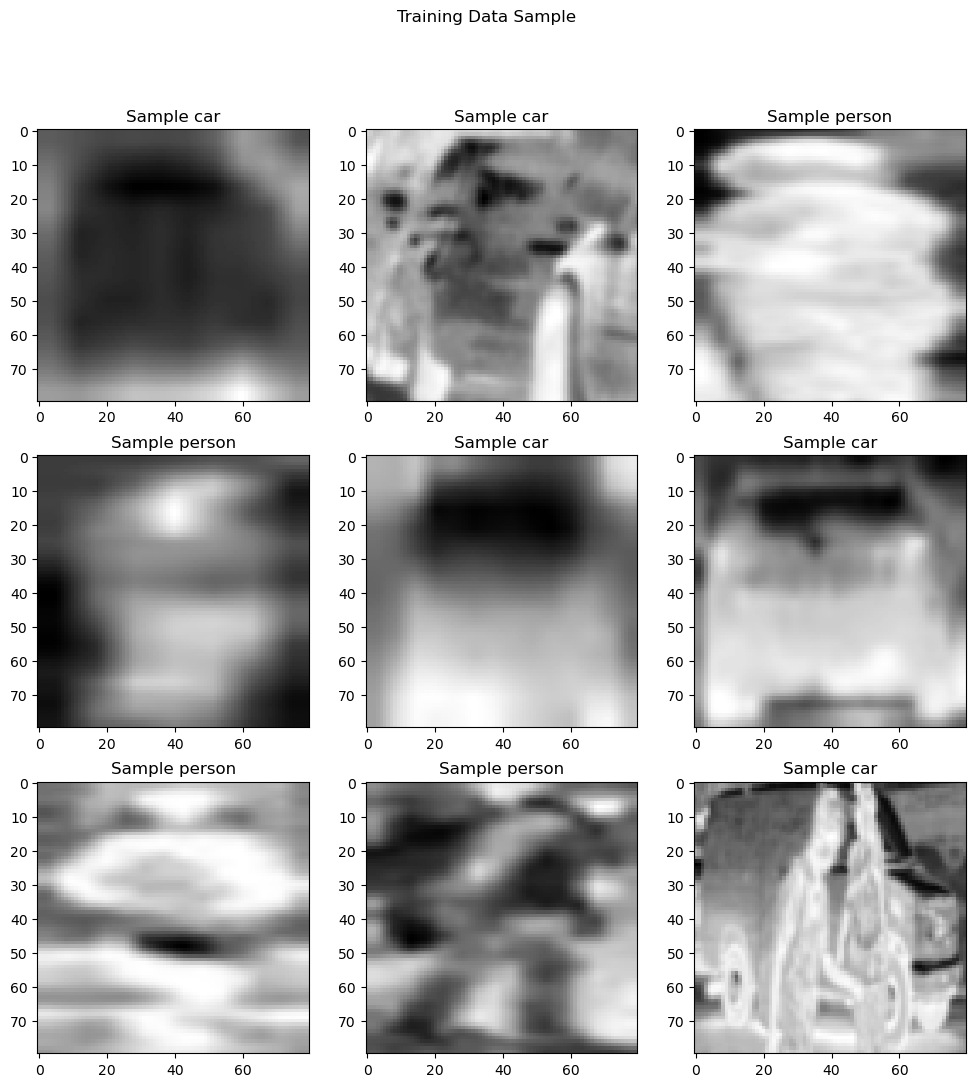

In [14]:
figure = plt.figure(figsize=(12, 12))
plt.suptitle('Training Data Sample')
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    idx = torch.randint(len(valDataClass), size=(1,)).item()
    image, labels, bboxes, num = valDataClass[idx]
    figure.add_subplot(rows, cols, i)
    plot_sample(image, labels.tolist(), bboxes.tolist(), num.item(), showbb=False)
if saveImagesVideos:
    plt.savefig(f'{samplesDir}/validation_class')
plt.show()

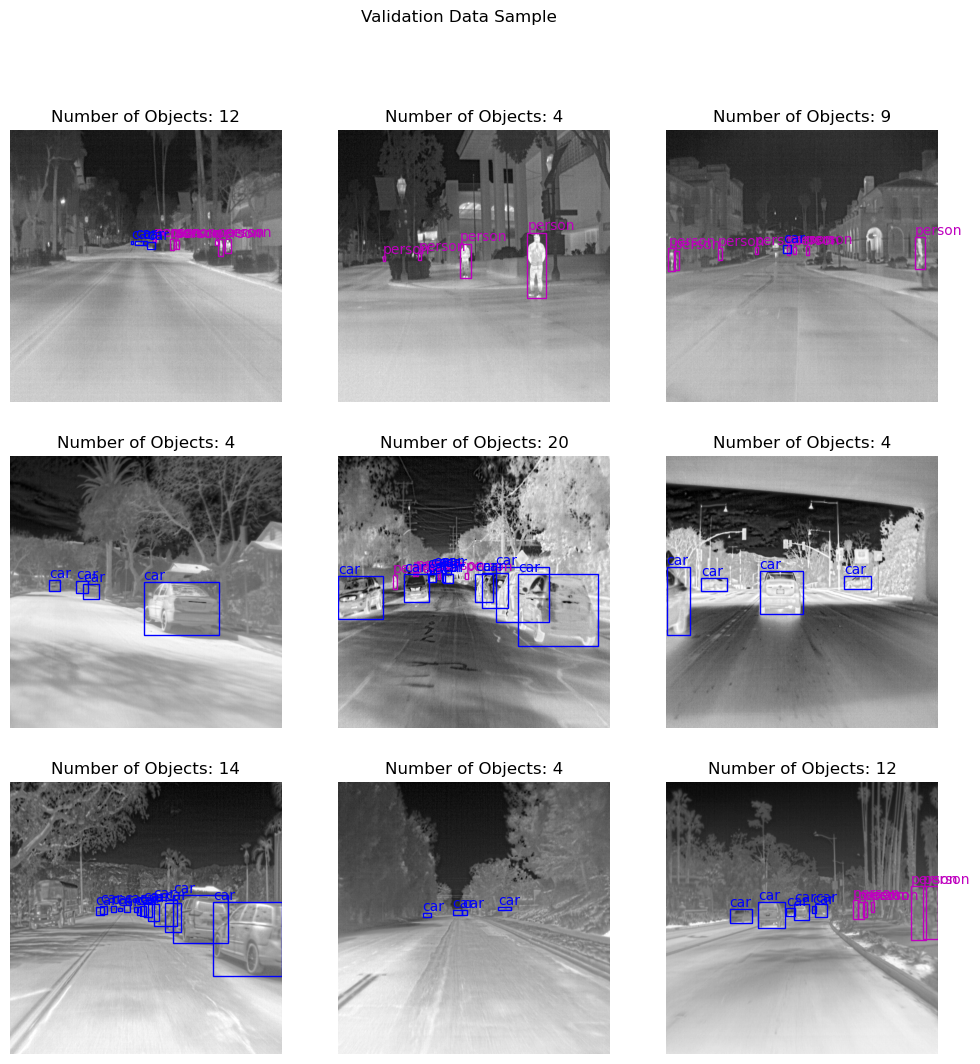

In [15]:
figure = plt.figure(figsize=(12, 12))
plt.suptitle('Validation Data Sample')

cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    idx = torch.randint(len(valDataDetect), size=(1,)).item()
    image, labels, bboxes, num = valDataDetect[idx]
    figure.add_subplot(rows, cols, i)
    labels = labels[:num]
    bboxes = bboxes[:num,:]
    plot_sample(image, labels.tolist(), bboxes.tolist(), num.item())
if saveImagesVideos:
    plt.savefig(f'{samplesDir}/validation_detect')
plt.show()

### Original Images (Testing)

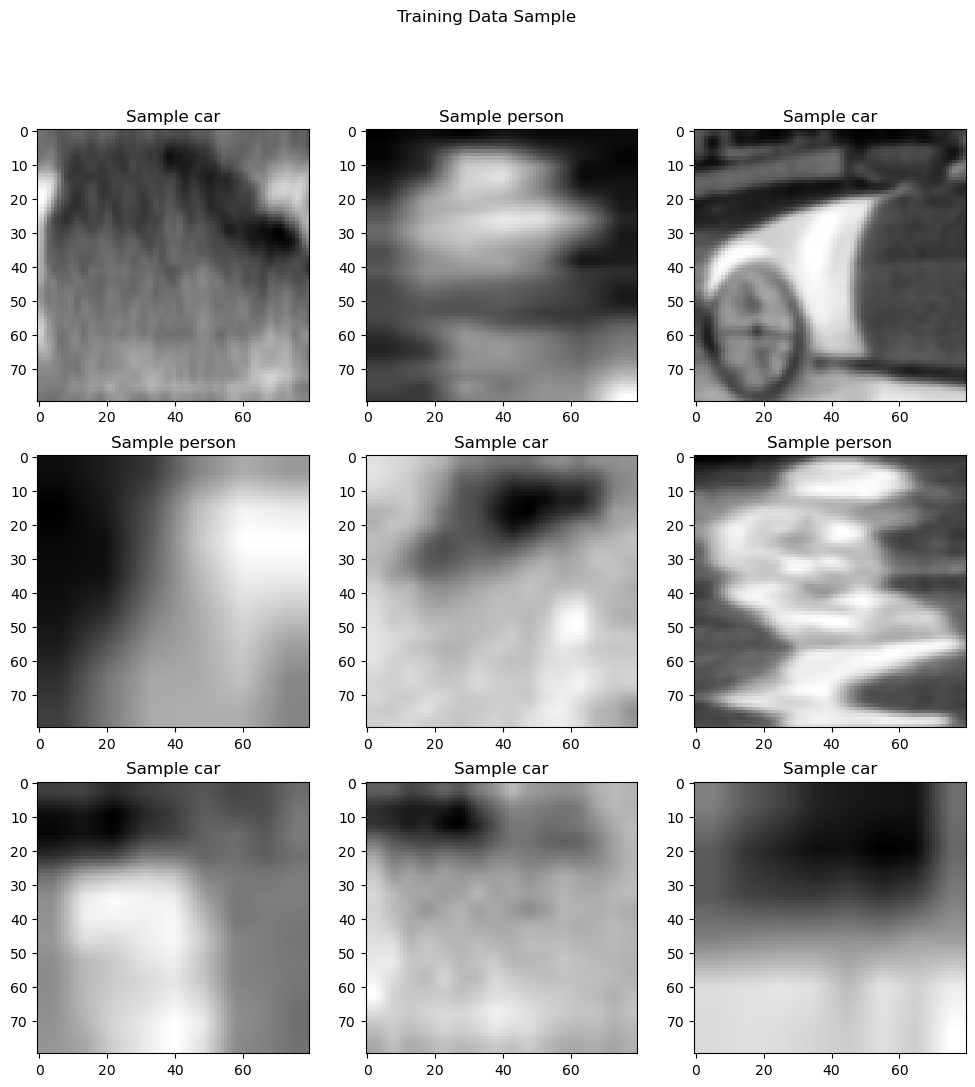

In [16]:
figure = plt.figure(figsize=(12, 12))
plt.suptitle('Training Data Sample')
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    idx = torch.randint(len(testDataClass), size=(1,)).item()
    image, labels, bboxes, num = testDataClass[idx]
    figure.add_subplot(rows, cols, i)
    plot_sample(image, labels.tolist(), bboxes.tolist(), num.item(), showbb=False)
if saveImagesVideos:
    plt.savefig(f'{samplesDir}/testing_class')
plt.show()

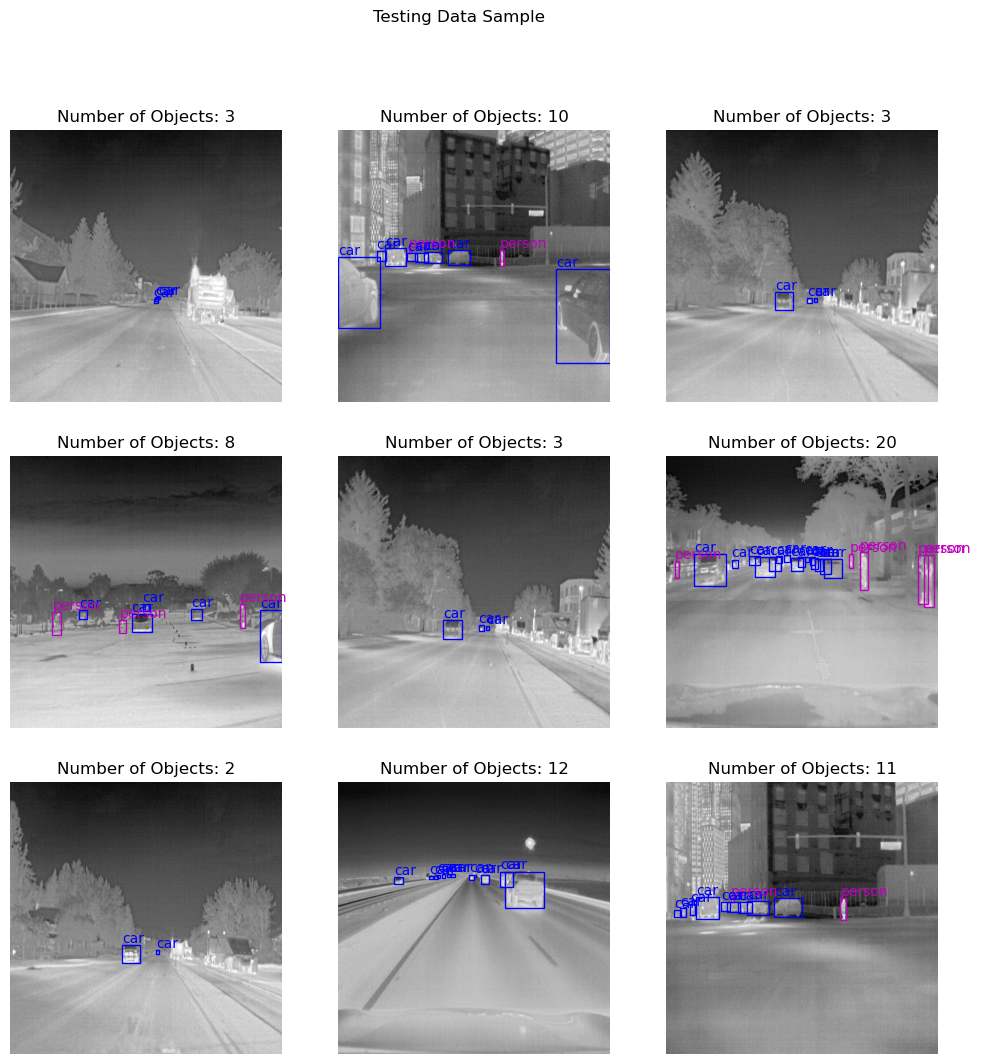

In [17]:
figure = plt.figure(figsize=(12, 12))
plt.suptitle('Testing Data Sample')
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    idx = torch.randint(len(testDataDetect), size=(1,)).item()
    image, labels, bboxes, num = testDataDetect[idx]
    figure.add_subplot(rows, cols, i)
    labels = labels[:num]
    bboxes = bboxes[:num,:]
    plot_sample(image, labels.tolist(), bboxes.tolist(), num.item())
if saveImagesVideos:
    plt.savefig(f'{samplesDir}/testing_detect')
plt.show()

## Model Definitions

![alt text](image.png)

## Classification Model

In [12]:
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        inplace = False
        self.batchNorm = nn.BatchNorm2d(1)
        resnet = models.resnet18(weights=None)
        
        self.relu = nn.ReLU(inplace=inplace)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        
        layers = list(resnet.children())[:6]
        self.features = nn.Sequential(*layers)
        
        self.classifier = nn.Sequential(nn.Linear(128, 32), 
                                         nn.ReLU(inplace=inplace), 
                                         nn.Linear(32, num_classes),
                                         nn.Softmax(1))
        
    def forward(self, x):
        x = self.batchNorm(x)
        x = self.features(x)
        x = self.relu(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        
        classifier_output = self.classifier(x)
        return classifier_output
    
classifier = Classifier(numClasses)

classifier = classifier.cpu()

if str(device) == 'cuda':
    classifier = classifier.to(device)

summary(classifier, (1,80,80))
print()

Layer (type:depth-idx)                   Output Shape              Param #
├─BatchNorm2d: 1-1                       [-1, 1, 80, 80]           2
├─Sequential: 1-2                        [-1, 128, 10, 10]         --
|    └─Conv2d: 2-1                       [-1, 64, 40, 40]          576
|    └─BatchNorm2d: 2-2                  [-1, 64, 40, 40]          128
|    └─ReLU: 2-3                         [-1, 64, 40, 40]          --
|    └─MaxPool2d: 2-4                    [-1, 64, 20, 20]          --
|    └─Sequential: 2-5                   [-1, 64, 20, 20]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 20, 20]          73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 20, 20]          73,984
|    └─Sequential: 2-6                   [-1, 128, 10, 10]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 10, 10]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 10, 10]         295,424
├─ReLU: 1-3                              [-1, 128, 10, 10]        

In [13]:
criterionClassifier = nn.CrossEntropyLoss()   
print(f'Criterion: {criterionClassifier}')

optimizerClassifier = optim.Adam(classifier.parameters(), lr = learnRateClass)   
print(f'\nOptimizer: {optimizerClassifier}')

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerClassifier, mode='min')
print(f'\nscheduler: {scheduler}')

Criterion: CrossEntropyLoss()

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7bffc5bdb080>


In [14]:
if loadClassifierModel:
    classifier = Classifier(numClasses)
    checkpoint = torch.load(classifierModelPath)
    classifier.load_state_dict(checkpoint['model_state_dict'])
    optimizerClassifier.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    trainLoss = [checkpoint['loss']]

In [15]:
classifier = classifier.to(device)
criterionClassifier = criterionClassifier.to(device)

if not loadClassifierModel:
        
    trainLoss = []
    trainAcc = []
    testLoss = []
    testAcc = []

    for epoch in range(1, maxEpochsClassifier+1):
        epochLoss = []
        epochAcc = []
        testEpochLoss = []
        testEpochAcc = []
        classifier.train()

        for i, (images, labels, __, __) in tqdm(enumerate(trainLoaderClass)):
            optimizerClassifier.zero_grad()
            
            if str(device) == 'cuda':
                images = images.to(device)
                outputs = classifier(images)
                labels = labels.to(device)
            
            loss = criterionClassifier(outputs, labels)
            loss.backward()          
            optimizerClassifier.step()
            lossVal = loss.item()
            
            pred = torch.max(outputs, 1)[1].data.squeeze()
            accuracy = (pred == labels).sum().item() / float(labels.size(0))

            epochLoss.append(float(lossVal))
            epochAcc.append(float(accuracy))
                
        trainLoss.append(np.mean(epochLoss))
        trainAcc.append(np.mean(epochAcc))
        scheduler.step(trainLoss[-1])
                
        classifier.eval()
        with torch.no_grad():
            for testImages, testLabels, __, __ in tqdm(valLoaderClass):
                testImages = testImages.to(device)
                testLabels = testLabels.to(device)
                    
                testOutput = classifier(testImages)
                lossVal = criterionClassifier(testOutput, testLabels)
            
                if str(device) == 'cuda':
                    lossVal = lossVal.cpu()
                    
                predVal = torch.max(testOutput, 1)[1].data.squeeze()
                accuracyVal = (predVal == testLabels).sum().item() / float(testLabels.size(0))
                
                testEpochLoss.append(lossVal)
                testEpochAcc.append(accuracyVal)
                
            testLoss.append(np.mean(testEpochLoss))
            testAcc.append(np.mean(testEpochAcc))
                
        print(f'\t[Epoch: {epoch}/{maxEpochsClassifier}] Train Loss: {np.round(trainLoss[-1], 5)}')
        print(f'\t[Epoch: {epoch}/{maxEpochsClassifier}] Test Loss: {np.round(testLoss[-1], 5)}')
        print(f'\t[Epoch: {epoch}/{maxEpochsClassifier}] Train Acc: {np.round(trainAcc[-1], 5)}')
        print(f'\t[Epoch: {epoch}/{maxEpochsClassifier}] Test Acc: {np.round(testAcc[-1], 5)}')

        if saveClassifierModel and epoch % 1 == 0: ## save model every 5th epoch
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': classifier.state_dict(),
                    'optimizer_state_dict': optimizerClassifier.state_dict(),
                    'loss': trainLoss[-1],
                    }, classifierModelPath)

In [22]:
if saveClassifierModel:
    torch.save({
            'epoch': epoch,
            'model_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optimizerClassifier.state_dict(),
            'loss': trainLoss[-1],
            }, classifierModelPath)

In [23]:
if not loadClassifierModel:
    print(f'Final MSE ({maxEpochsClassifier} epochs): {trainLoss[-1]}\n')
    
    f = plt.figure(figsize=(10,8))
    plt.plot(trainLoss, label="train")
    plt.plot(testLoss, label="val")
    plt.xlabel("epochs")
    plt.ylabel("CrossEntropy")
    plt.title("Epochs vs. Loss Function")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    if saveImagesVideos:
        plt.savefig(f'{samplesDir}/class_loss')
    plt.show()
       
    f = plt.figure(figsize=(10,8))
    plt.plot(trainAcc, label="train")
    plt.plot(testAcc, label="test")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title("Epochs vs. Accuracy")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    if saveImagesVideos:
        plt.savefig(f'{samplesDir}/class_accuracy')
    plt.show()

In [24]:
predictions = []
actuals = []
classifier.eval()
with torch.no_grad():
    for images, labels, __, __ in tqdm(testLoaderClass):
        images = images.to(device)
        labels = labels.to(device)
            
        test_output = classifier(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        predictions.extend(pred_y.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

100%|██████████| 670/670 [01:33<00:00,  7.14it/s]



Correct classifications on 42840 images: 41750/42840 | 97.4556%


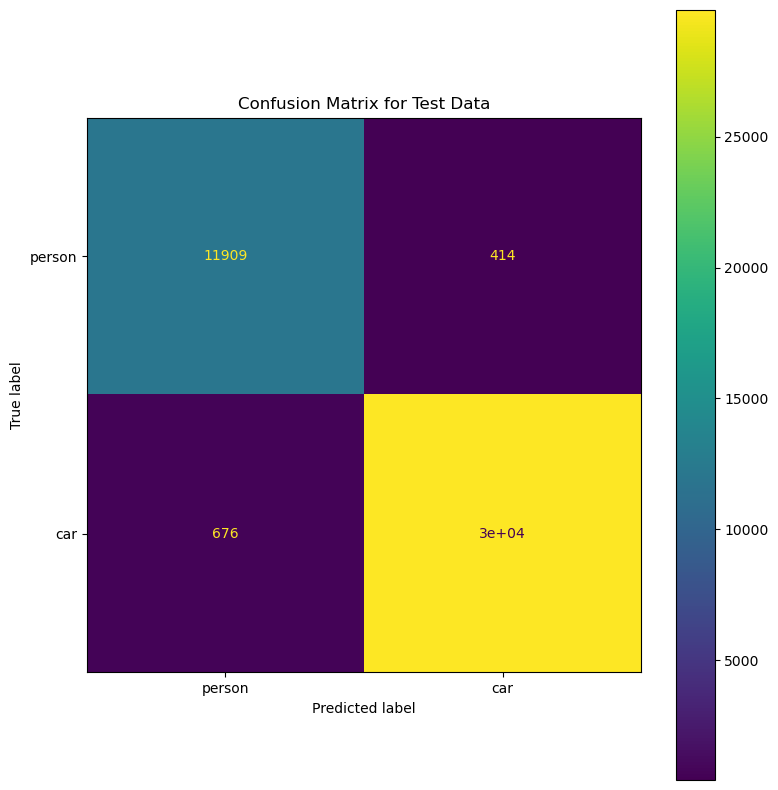

In [25]:
errorCount = [predictions[i] == actuals[i] for i in range(len(actuals))]
acc = np.sum(errorCount)/len(predictions)*100
print(f"\nCorrect classifications on {len(predictions)} images: {np.sum(errorCount)}/{len(predictions)} | {np.round(acc, 4)}%")

## Create Confusion matrix
f, ax = plt.subplots(figsize=(8,8))
confusion_matrix = metrics.confusion_matrix(actuals, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=trackingLabels)

cm_display.plot(ax=ax)
plt.title("Confusion Matrix for Test Data")
plt.tight_layout()

if saveImagesVideos:
    plt.savefig(f'{samplesDir}/confusion_matrix_classifier')

plt.show()

In [26]:
predictions = np.array(predictions).reshape(len(predictions), 1)
actuals = np.array(actuals).reshape(len(actuals), 1)
bidxs = np.where(actuals != predictions)[0]
gidxs = np.where(actuals == predictions)[0]

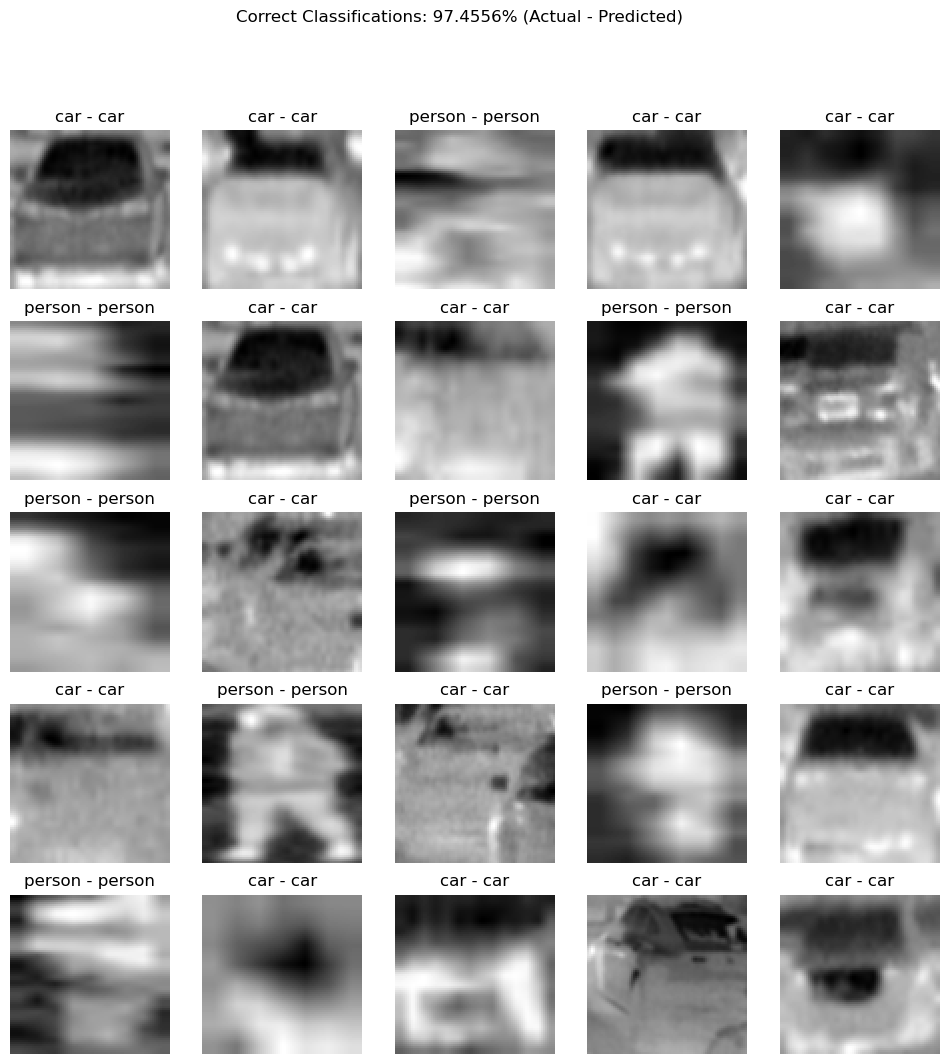

In [27]:
figure = plt.figure(figsize=(12, 12))
plt.suptitle(f'Correct Classifications: {np.round(len(gidxs)/len(predictions)*100,4)}% (Actual - Predicted)')
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(gidxs), size=(1,)).item()
    sample_idx = gidxs[sample_idx]
    img, label, __, __ = testDataClass[sample_idx]
    pred = predictions[sample_idx]
    act = actuals[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'{trackingLabels[label]} - {trackingLabels[pred[0]]}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
if saveImagesVideos:
    plt.savefig(f'{samplesDir}/test_classifications_correct')
    
plt.show()

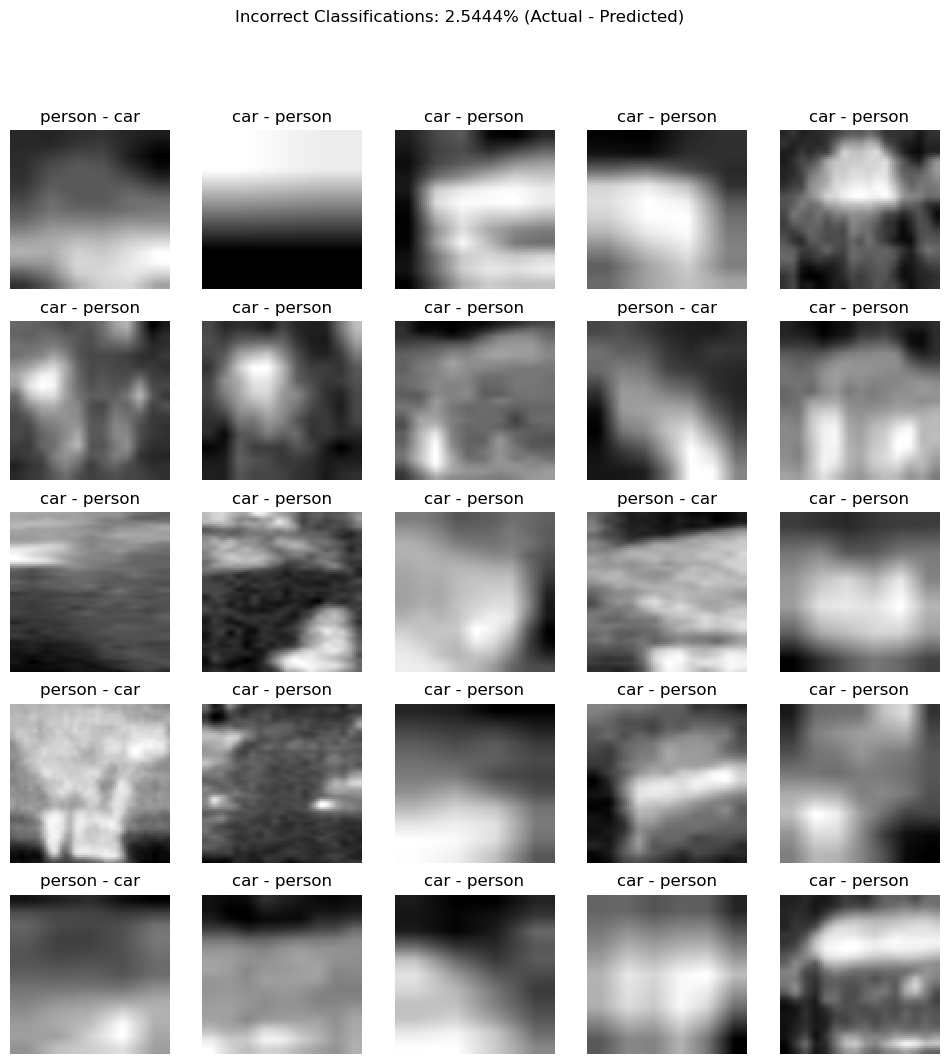

In [28]:
figure = plt.figure(figsize=(12, 12))
plt.suptitle(f'Incorrect Classifications: {np.round(len(bidxs)/len(predictions)*100,4)}% (Actual - Predicted)')
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(bidxs), size=(1,)).item()
    sample_idx = bidxs[sample_idx]
    img, label, __, __ = testDataClass[sample_idx]
    pred = predictions[sample_idx]
    act = actuals[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'{trackingLabels[label]} - {trackingLabels[pred[0]]}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
if saveImagesVideos:
    plt.savefig(f'{samplesDir}/test_classifications_incorrect')

plt.show()

## Detection Model

In [16]:
class Detector(nn.Module):
    def __init__(self, max_objects):
        super(Detector, self).__init__()

        resnet = models.resnet18(weights='DEFAULT')
        
        self.relu = nn.ReLU(inplace=True)
        
        # Freeze parameters of the ResNet layers
        for param in resnet.parameters():
            param.requires_grad = False
        
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=1, bias=False)
        
        layers = list(resnet.children())[:-1]
        self.features = nn.Sequential(*layers)
        
        self.max_objects = max_objects
        
        self.bb = nn.Sequential(nn.Linear(512, 64),
                                nn.ReLU(inplace=True),
                                nn.Linear(64, 4*max_objects))
        
    def forward(self, x):
        x = self.features(x)
        x = self.relu(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        
        x = self.bb(x)
        return x
    
detector = Detector(maxObjects)

detector = detector.cpu()

if str(device) == 'cuda':
    detector = detector.to(device)

summary(detector, (1,640,640))
print()

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 318, 318]        3,136
|    └─BatchNorm2d: 2-2                  [-1, 64, 318, 318]        (128)
|    └─ReLU: 2-3                         [-1, 64, 318, 318]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 159, 159]        --
|    └─Sequential: 2-5                   [-1, 64, 159, 159]        --
|    |    └─BasicBlock: 3-1              [-1, 64, 159, 159]        (73,984)
|    |    └─BasicBlock: 3-2              [-1, 64, 159, 159]        (73,984)
|    └─Sequential: 2-6                   [-1, 128, 80, 80]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 80, 80]         (230,144)
|    |    └─BasicBlock: 3-4              [-1, 128, 80, 80]         (295,424)
|    └─Sequential: 2-7                   [-1, 256, 40, 40]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 40

## Set Criterion and Optimizer

In [17]:
# Define the loss function
criterionDetector = nn.SmoothL1Loss()
print(f'\nCriterion: {criterionDetector}')

# Define optimizer and learning rate scheduler
optimizerDetector = optim.Adam(detector.parameters(), lr=learnRateDetect)
print(f'\nOptimizer: {optimizerDetector}')

schedulerDetector = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerDetector, mode='min')
print(f'\nscheduler: {schedulerDetector}')


Criterion: SmoothL1Loss()

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7bffc4bee000>


In [18]:
# class DetectionLoss(nn.Module):
#     def __init__(self, iou_weight=1.0):
#         super(DetectionLoss, self).__init__()
#         self.iou_weight = iou_weight
#         self.bbox_loss = nn.SmoothL1Loss()
#         # self.iou_loss = nn.MSELoss()

#     def forward(self, pred_bboxes, num, true_bboxes):
#         """
#         Calculate the combined loss incorporating IoU loss without using ground truth labels.

#         Parameters:
#             pred_bboxes (Tensor): Predicted bounding boxes of shape (batch_size, max_objects, 4).
#             num (Tensor): Number of objects in each image of shape (batch_size,).
#             true_bboxes (Tensor): Ground truth bounding boxes of shape (batch_size, max_objects, 4).

#         Returns:
#             Tensor: Combined loss.
#         """
        
#         num = torch.max(num)
#         preds = pred_bboxes[:, :num, :]
#         truths = true_bboxes[:, :num, :]
#         preds = torch.flatten(preds)
#         truths = torch.flatten(truths)

#         # Bounding box regression loss
#         bbox_loss = self.bbox_loss(preds, truths)
#         return bbox_loss

#         # IoU-based loss
#         # iou_loss = float(self.iou_loss(preds, truths))

#         # Combine losses
#         # total_loss = bbox_loss + self.iou_weight * iou_loss

#         # return total_loss
        
# class DetectionLoss(nn.Module):
#     def __init__(self):
#         super(DetectionLoss, self).__init__()
#         self.bboxLoss = nn.SmoothL1Loss()

#     def forward(self, bboxesPred, num, bboxes):        
#         num = torch.max(num)
#         loss = self.bboxLoss(bboxesPred, bboxes)
#         return loss

# class DetectorLoss(nn.Module):
#     def __init__(self):
#         super(DetectorLoss, self).__init__()
#         self.bce = nn.BCEWithLogitsLoss(reduction='sum')
#         self.bbox = nn.SmoothL1Loss(reduction='sum')

#     def forward(self, predictions, targets):
#         # Extract predicted bounding boxes and confidence scores
#         pred_boxes = predictions[..., :4]
#         pred_conf = predictions[..., 4]

#         # Extract target bounding boxes
#         true_boxes = targets[..., :4]

#         # Calculate binary cross-entropy loss for confidence scores
#         conf_loss = self.bce(pred_conf, torch.ones_like(pred_conf))

#         # Compute Mean Squared Error (MSE) loss for bounding box predictions
#         bbox_loss = self.bbox(pred_boxes, true_boxes)

#         return conf_loss + bbox_loss

# # # criterionDetector = DetectionLoss()
# criterionDetector = DetectorLoss()
# print(f'\nCriterion: {criterionDetector}')

# # Define optimizer and learning rate scheduler
# optimizerDetector = optim.Adam(detector.parameters(), lr=learnRateDetect)
# print(f'\nOptimizer: {optimizerDetector}')

# schedulerDetector = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerDetector, mode='min')
# print(f'\nscheduler: {schedulerDetector}')

## Load Trained Model (If Needed)

In [19]:
if loadDetectionModel:
    detector = Detector(maxObjects)
    checkpoint = torch.load(detectorModelPath)
    detector.load_state_dict(checkpoint['model_state_dict'])
    optimizerDetector.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']  

## Train Detector Model

In [20]:
criterionDetector = criterionDetector.to(device)

if not loadDetectionModel:
        
    trainLossDetector = []
    testLossDetector = []

    for epoch in range(1, maxEpochsDetect+1):
        epochLoss = []
        testEpochLoss = []
        detector.train()

        for i, (images, labels, bboxes, num) in tqdm(enumerate(trainLoaderDetect)):
            optimizerDetector.zero_grad()
            
            if str(device) == 'cuda':
                images = images.to(device)
                bboxes = bboxes.to(device)
                num = num.to(device)
                
            outputs = detector(images)
            outputs = torch.flatten(outputs)[:4*num]
            bboxes = torch.flatten(bboxes)[:4*num]
            loss = criterionDetector(outputs, bboxes)
            loss.backward()          
            optimizerDetector.step()
            lossVal = loss.item()
            
            epochLoss.append(float(lossVal))
        trainLossDetector.append(np.mean(epochLoss))
        schedulerDetector.step(trainLossDetector[-1])
        
        detector.eval()
        with torch.no_grad():
            for testImages, testLabels, testBoxes, testNum, in tqdm(valLoaderDetect):
                if str(device) == 'cuda':
                    testImages = testImages.to(device)
                    testBoxes = testBoxes.to(device)
                    testNum = testNum.to(device)
                    
                testOutputs = detector(testImages)
                testOutputs = torch.flatten(testOutputs)[:4*testNum]
                testBoxes = torch.flatten(testBoxes)[:4*testNum]
                lossVal = criterionDetector(testOutputs, testBoxes)
            
                if str(device) == 'cuda':
                    lossVal = lossVal.cpu()  
                testEpochLoss.append(lossVal) 
            testLossDetector.append(np.mean(testEpochLoss))
                
        print(f'\t[Epoch: {epoch}/{maxEpochsDetect}] Train Loss: {np.round(trainLossDetector[-1], 5)}')
        print(f'\t[Epoch: {epoch}/{maxEpochsDetect}] Test Loss: {np.round(testLossDetector[-1], 5)}')

        if saveDetectionModel and epoch % 1 == 0:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': detector.state_dict(),
                    'optimizer_state_dict': optimizerDetector.state_dict(),
                    'loss': trainLossDetector[-1],
                    }, detectorModelPath)

## Save Model (If Needed)

In [34]:
if saveDetectionModel:
    torch.save({
            'epoch': epoch,
            'model_state_dict': detector.state_dict(),
            'optimizer_state_dict': optimizerDetector.state_dict(),
            'loss': trainLossDetector[-1],
            }, detectorModelPath)

## Learning Curve

Final MSE (20 epochs): 48.553116883805245



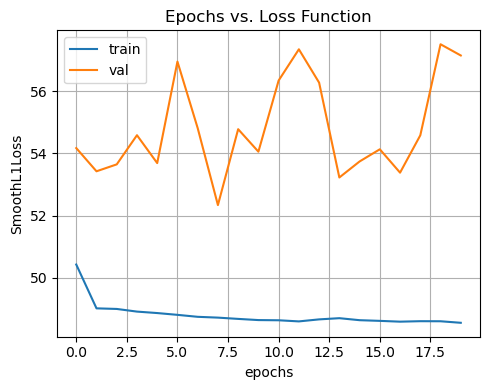

In [35]:
if not loadDetectionModel:
    print(f'Final MSE ({maxEpochsDetect} epochs): {trainLossDetector[-1]}\n')
    
    f = plt.figure(figsize=(5,4))
    plt.plot(trainLossDetector, label="train")
    plt.plot(testLossDetector, label="val")
    plt.xlabel("epochs")
    plt.ylabel("SmoothL1Loss")
    plt.title("Epochs vs. Loss Function")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    if saveImagesVideos:
        plt.savefig(f'{samplesDir}/detect_loss')
    plt.show()

# Object Detection and Classification

## Generate Images and Movies

In [22]:
detector = detector.to(device)

idx = 0
detector.eval()
with torch.no_grad():
    for images, labels, bboxes, num in tqdm(testLoaderDetect):
        if idx%20 == 0:
            figure = plt.figure(figsize=(8, 4))
            plt.suptitle('Truth Data vs Predicted Data')
            try:
                labels0 = labels.squeeze()[:num]
            except:
                labels0 = labels[:num]
            try:
                bboxes0 = bboxes.squeeze()[:num,:]
            except:
                bboxes0 = bboxes.squeeze().unsqueeze(0)[:num,:]
            figure.add_subplot(1, 2, 1)
            plot_sample(images.detach().cpu(), labels0.tolist(), bboxes0.tolist(), num.item())
            
            figure.add_subplot(1, 2, 2)
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)
            num = num.to(device)
            predBoxes = detector(images)
            predBoxes = predBoxes.view(-1, maxObjects, 4)
            
            predLabels = []
            predScores = []
            boxesKeep = []
            for box in predBoxes.squeeze():
                if not torch.all(box > 1):
                    continue

                img = sizeBoxImage(images.squeeze().detach().cpu().numpy(), box)
                img = transform(img).unsqueeze(0)
                output = classifier(img.to(device))
                predLabels.append(torch.max(output, 1)[1].data.squeeze().item())
                predScores.append(torch.max(output, 1)[0].data.squeeze().item())
                boxesKeep.append(box.detach().cpu().tolist())
                
            try:
                boxesKeep = torch.tensor(boxesKeep)
            except:
                boxesKeep = torch.tensor(boxesKeep)
            plot_sample(images.detach().cpu(), predLabels, boxesKeep.tolist(), num.item())
            if saveImagesVideos:
                plt.savefig(f"{finalImagery}/{idx}")
            plt.close()
        idx += 1

  0%|          | 0/3493 [00:00<?, ?it/s]

100%|██████████| 3493/3493 [01:41<00:00, 34.58it/s]


In [23]:
# Video Generating function 
def generate_video(): 
    image_folder = f'{finalImagery}' # make sure to use your folder 
    video_name = f'{videosDir}/finalVideo.avi'
      
    unsorted_images = [img for img in os.listdir(image_folder) 
              if img.endswith(".jpg") or
                 img.endswith(".jpeg") or
                 img.endswith("png")] 
              
    images = sorted(unsorted_images, key=lambda x: int(x.split('.')[0]))
  
    frame = cv2.imread(os.path.join(image_folder, images[0])) 
  
    # setting the frame width, height width 
    # the width, height of first image 
    height, width, layers = frame.shape   
  
    video = cv2.VideoWriter(video_name, 0, 60, (width, height))  
  
    # Appending the images to the video one by one 
    for image in images:  
        video.write(cv2.imread(os.path.join(image_folder, image)))  
      
    # Deallocating memories taken for window creation 
    cv2.destroyAllWindows()  
    video.release()  # releasing the video generated 
  
  
# Calling the generate_video function
if saveImagesVideos:
    generate_video() 